In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tamil_nadu_rural_bus_dataset_enriched_100k.csv to tamil_nadu_rural_bus_dataset_enriched_100k.csv


In [ ]:
# ================================
# DATA PREPROCESSING FOR ENRICHED DATASET
# ================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load enriched dataset
df = pd.read_csv("tamil_nadu_rural_bus_dataset_enriched_100k.csv")
print("✅ Dataset loaded. Shape:", df.shape)

✅ Dataset loaded. Shape: (100000, 21)


In [ ]:
# -------------------------------
# 1. Drop unnecessary columns
# -------------------------------
if "bus_id" in df.columns:
    df = df.drop(columns=["bus_id"])
if "stop_id" in df.columns:
    df = df.drop(columns=["stop_id"])

In [ ]:
# -------------------------------
# 2. Handle datetime columns
# -------------------------------
df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'], errors='coerce')
df['actual_arrival'] = pd.to_datetime(df['actual_arrival'], errors='coerce')

# Drop rows with invalid times
df = df.dropna(subset=['scheduled_arrival', 'actual_arrival'])

In [ ]:
# -------------------------------
# 3. Time-based features
# -------------------------------
df['scheduled_hour'] = df['scheduled_arrival'].dt.hour
df['scheduled_minute'] = df['scheduled_arrival'].dt.minute
df['scheduled_second'] = df['scheduled_arrival'].dt.second
df['day_of_week_num'] = df['scheduled_arrival'].dt.dayofweek  # numeric day

# Cyclical encoding of time (better for ML)
df['time_sin'] = np.sin(2*np.pi*(df['scheduled_hour']*60+df['scheduled_minute'])/1440)
df['time_cos'] = np.cos(2*np.pi*(df['scheduled_hour']*60+df['scheduled_minute'])/1440)

# Peak hour + weekend
df['is_peak'] = df['scheduled_hour'].isin(list(range(7,11)) + list(range(17,21))).astype(int)
df['is_weekend'] = df['day_of_week_num'].isin([5,6]).astype(int)

# -------------------------------
# 4. Delay features (target consistency)
# -------------------------------
df['calculated_delay'] = (df['actual_arrival'] - df['scheduled_arrival']).dt.total_seconds() / 60
df['delay_minutes'] = df['delay_minutes'].fillna(df['calculated_delay'])
df['delay_minutes'] = df['delay_minutes'].clip(lower=0)  # No negative delays

In [ ]:
# -------------------------------
# 5. Categorical feature cleanup
# -------------------------------
categorical_cols = ['traffic_level', 'weather', 'route_id',
                    'bus_type', 'road_condition', 'season']

for col in categorical_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [ ]:
# -------------------------------
# 6. Feature Engineering (reduce variance)
# -------------------------------
# Rush hour intensity
traffic_map = {'low':1, 'medium':2, 'high':3}
df['traffic_level_num'] = df['traffic_level'].map(traffic_map)

df['rush_intensity'] = np.where(df['is_peak']==1, df['traffic_level_num']*2, df['traffic_level_num'])

# Route-level stats (mean/quantiles of delay per route)
route_delay_mean = df.groupby('route_id')['delay_minutes'].transform('mean')
route_delay_q25 = df.groupby('route_id')['delay_minutes'].transform(lambda x: x.quantile(0.25))
route_delay_q75 = df.groupby('route_id')['delay_minutes'].transform(lambda x: x.quantile(0.75))

df['route_delay_mean'] = route_delay_mean
df['route_delay_q25'] = route_delay_q25
df['route_delay_q75'] = route_delay_q75

# Route frequency
df['route_freq'] = df['route_id'].map(df['route_id'].value_counts(normalize=True))

In [ ]:
# -------------------------------
# 8. Save preprocessed dataset
# -------------------------------
df.to_csv("tamil_nadu_bus_sample_enriched_processed.csv", index=False)
print("📂 Preprocessed dataset saved as tamil_nadu_bus_sample_enriched_processed.csv")

📂 Preprocessed dataset saved as tamil_nadu_bus_sample_enriched_processed.csv


EXPLORATORY DATA ANALYSIS(EDA) FOR PREPROCESSED DATASET

In [ ]:
# =============================
# EDA for Preprocessed Dataset
# =============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# --- Load dataset ---
df_processed = pd.read_csv("tamil_nadu_bus_sample_enriched_processed.csv")

# --- Basic Info ---
print("Shape:", df_processed.shape)
print("Columns:", df_processed.columns.tolist())
print("\nMissing Values:\n", df_processed.isnull().sum())
print("\nData Types:\n", df_processed.dtypes)

Shape: (100000, 34)
Columns: ['route_id', 'scheduled_arrival', 'traffic_level', 'weather', 'day_of_week', 'delay_minutes', 'actual_arrival', 'bus_age', 'bus_type', 'route_distance_km', 'num_stops', 'road_condition', 'has_railway_crossing', 'is_holiday', 'season', 'festival_flag', 'rain_intensity', 'temperature', 'wind_speed', 'scheduled_hour', 'scheduled_minute', 'scheduled_second', 'day_of_week_num', 'time_sin', 'time_cos', 'is_peak', 'is_weekend', 'calculated_delay', 'traffic_level_num', 'rush_intensity', 'route_delay_mean', 'route_delay_q25', 'route_delay_q75', 'route_freq']

Missing Values:
 route_id                0
scheduled_arrival       0
traffic_level           0
weather                 0
day_of_week             0
delay_minutes           0
actual_arrival          0
bus_age                 0
bus_type                0
route_distance_km       0
num_stops               0
road_condition          0
has_railway_crossing    0
is_holiday              0
season                  0
festiva

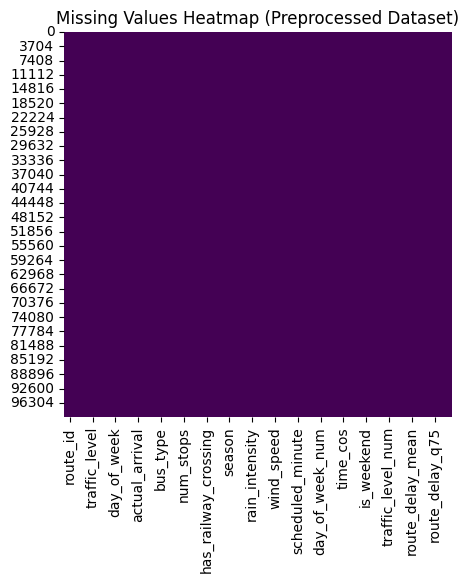

In [ ]:
# =============================
# 1. Missing Values Heatmap
# =============================
plt.figure(figsize=(5,5))
sns.heatmap(df_processed.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Preprocessed Dataset)")
plt.show()

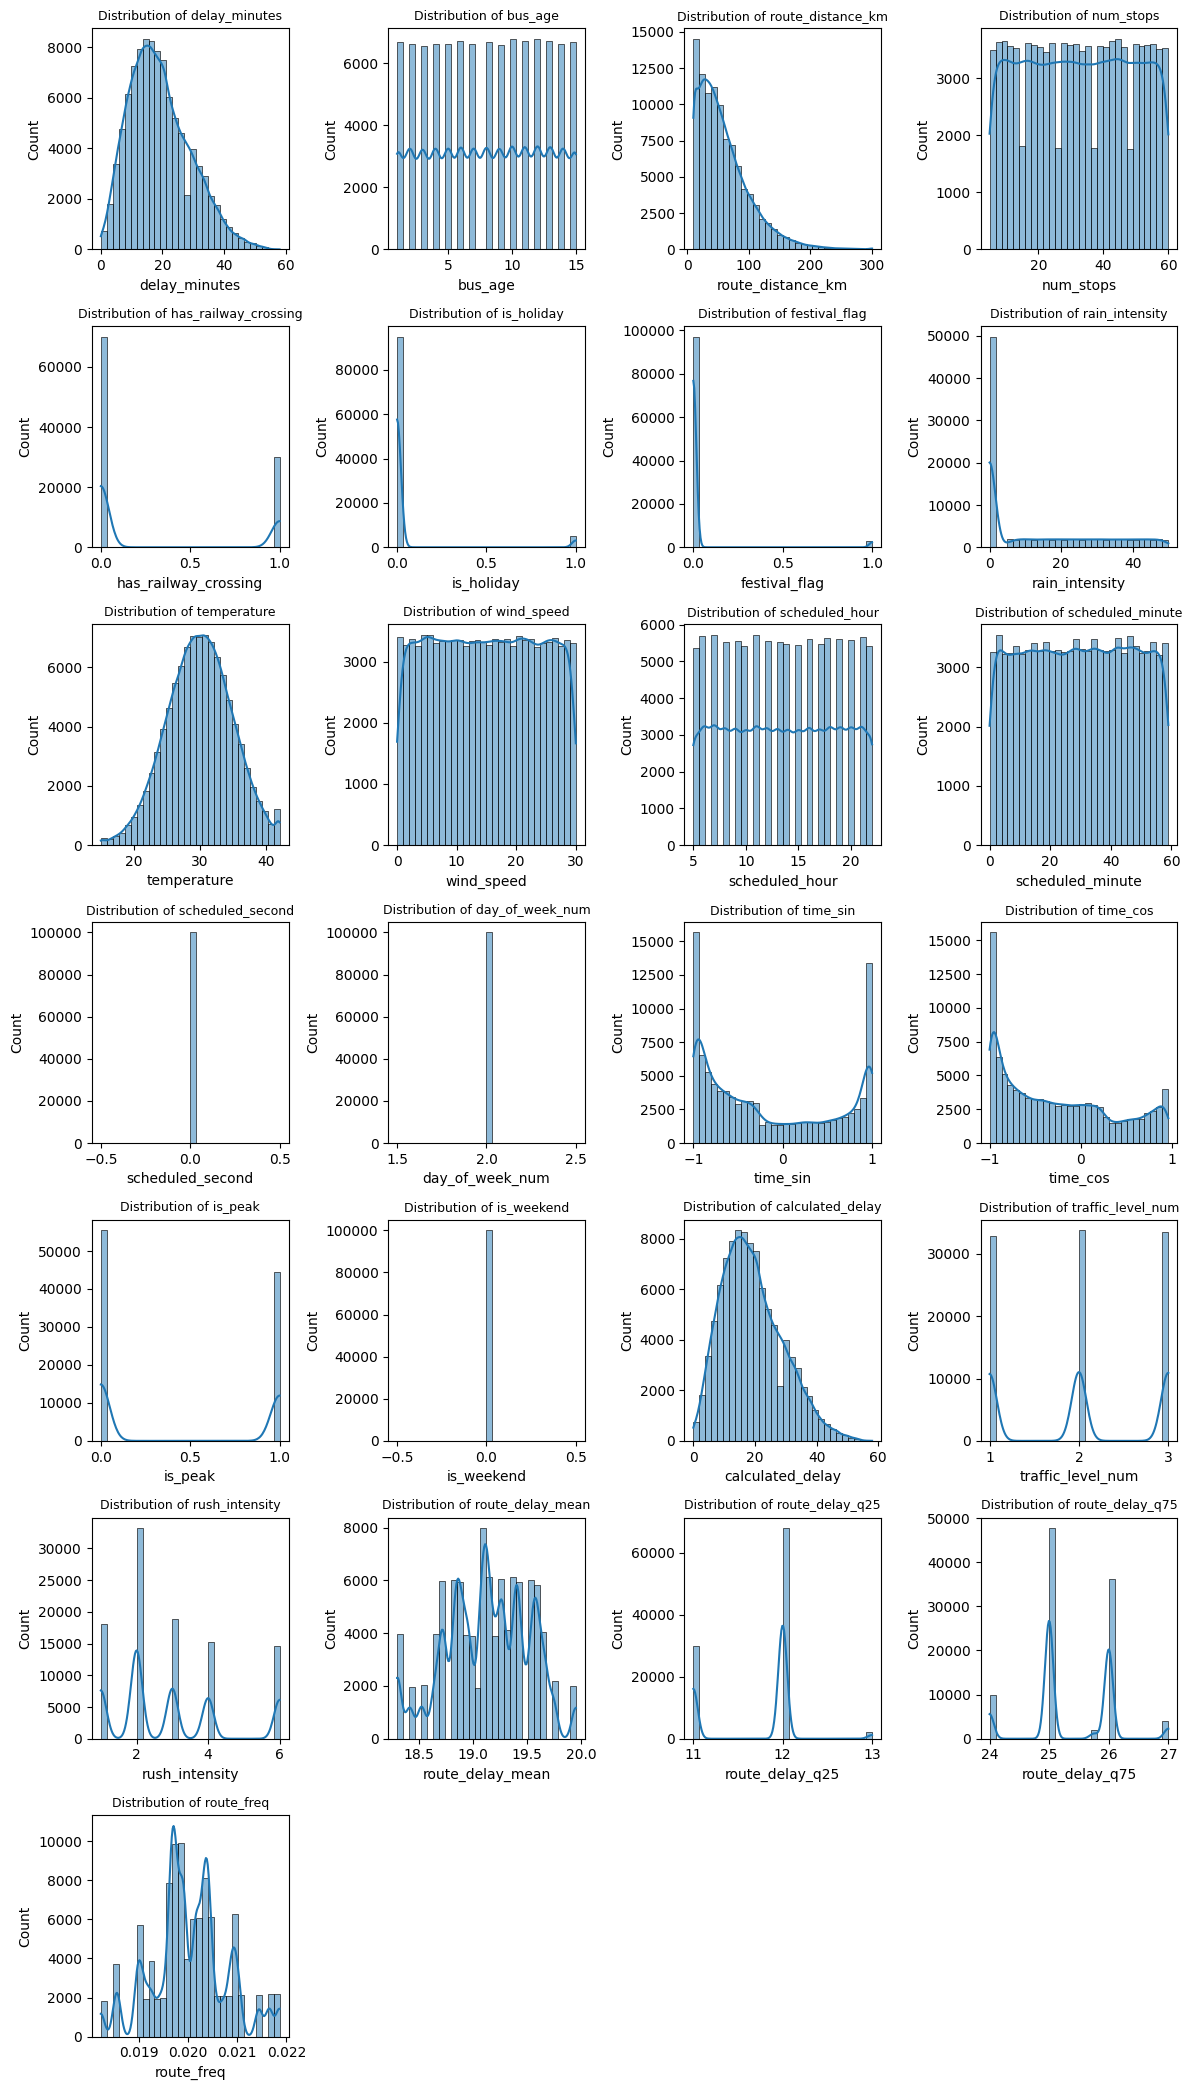

In [ ]:
# =============================
# 2. Distributions of Numerical Columns
# =============================
num_cols = df_processed.select_dtypes(include=[np.number]).columns

n_cols = 4   # 4 plots per row
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_processed[col].dropna(), kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=9)

# Remove empty plots if num_cols not multiple of 4
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


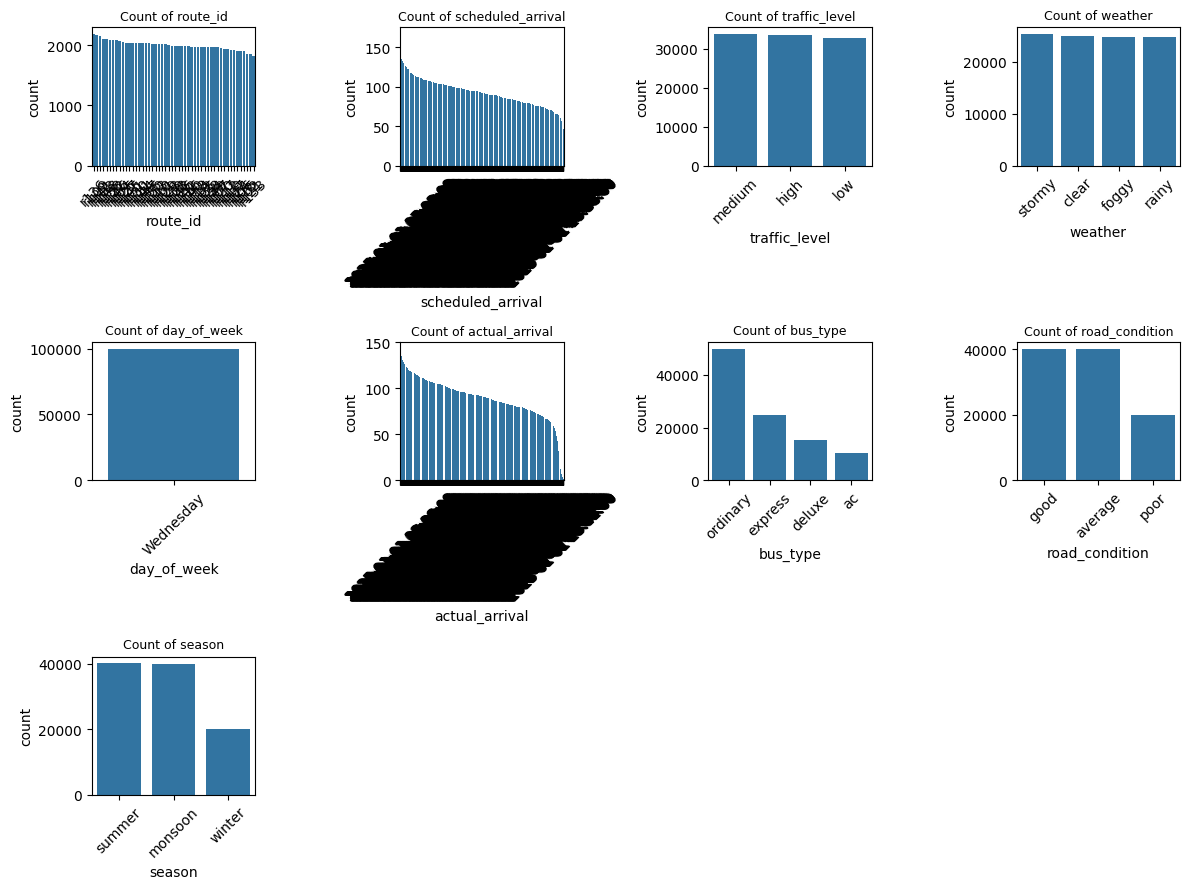

In [ ]:
# =============================
# 3. Count Plots for Categorical Columns
# =============================
cat_cols = df_processed.select_dtypes(include=['object']).columns

n_cols = 4   # 4 plots per row
n_rows = int(np.ceil(len(cat_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(data=df_processed, x=col, order=df_processed[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Count of {col}", fontsize=9)
    axes[i].tick_params(axis="x", rotation=45)

# Remove extra plots if cat_cols not multiple of 4
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


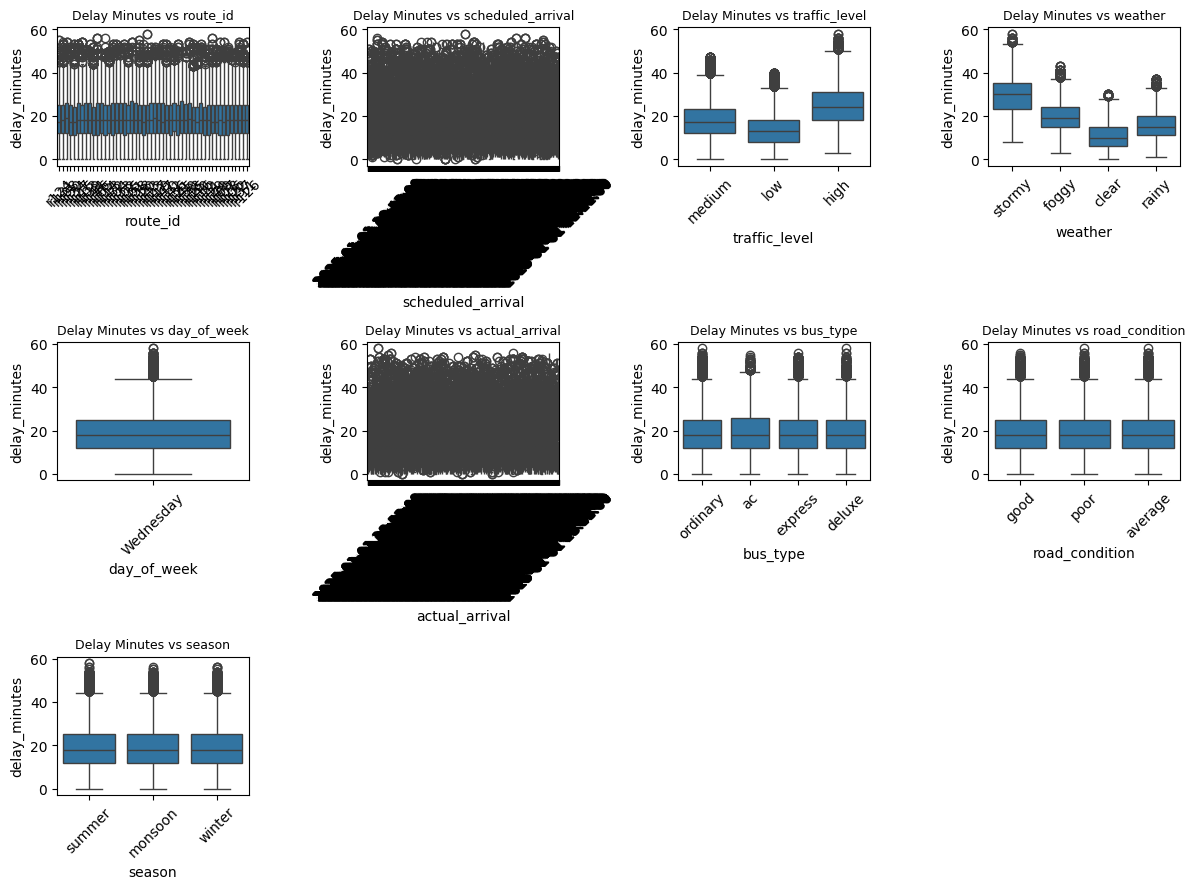

In [ ]:
# =============================
# 4. Boxplots: Delay vs Categorical
# =============================
if "delay_minutes" in df_processed.columns:
    n_cols = 4   # 4 plots per row
    n_rows = int(np.ceil(len(cat_cols) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    axes = axes.flatten()

    for i, col in enumerate(cat_cols):
        sns.boxplot(data=df_processed, x=col, y="delay_minutes", ax=axes[i])
        axes[i].set_title(f"Delay Minutes vs {col}", fontsize=9)
        axes[i].tick_params(axis="x", rotation=45)

    # Remove empty axes if number of plots < grid size
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


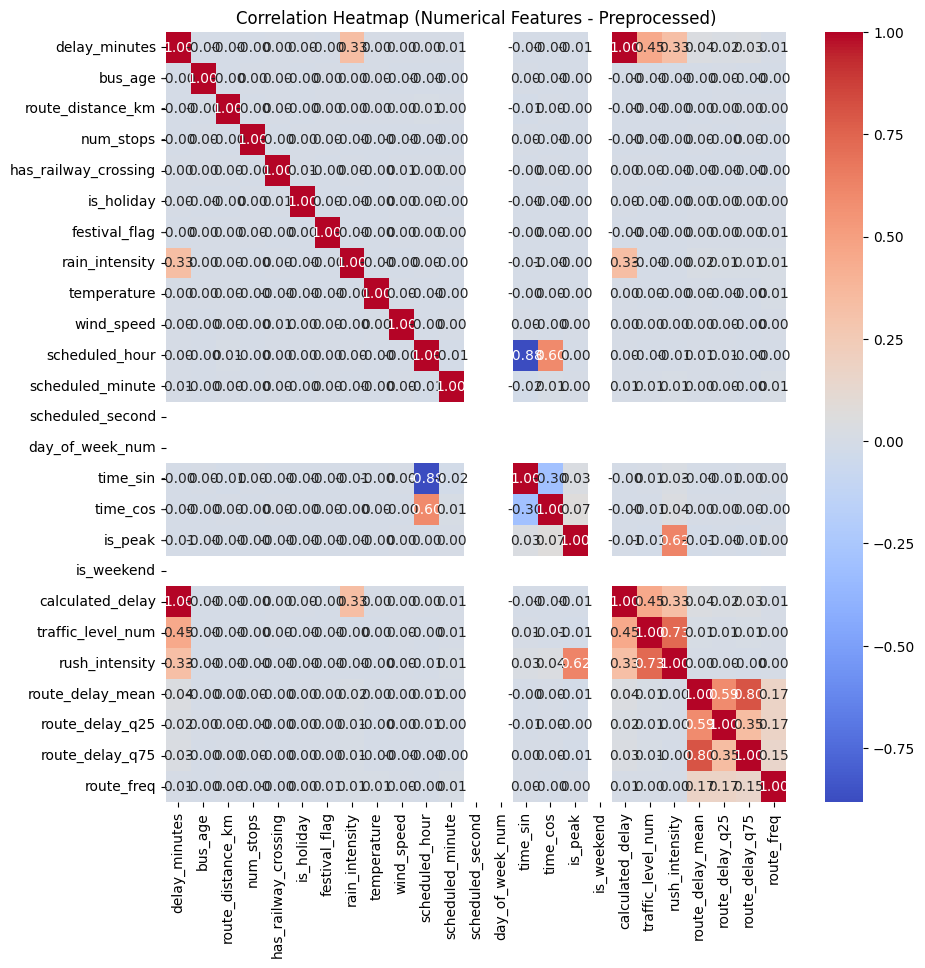

In [ ]:
# =============================
# 5. Correlation Heatmap (Numerical Features)
# =============================
plt.figure(figsize=(10,10))
sns.heatmap(df_processed[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features - Preprocessed)")
plt.show()
